# Results and comparison of ARIMA and G-VAR 

In [84]:
import statsmodels.api as sm
import seaborn as sns

import numpy as np
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
import pickle # to access dataframe faster than csv
import glob, re
import os
import csv
from pathlib import Path
import scipy as sp
import networkx
import torch_geometric
import torch
import utils
%load_ext autoreload
%autoreload 2
import arima.arima as arima

register_matplotlib_converters()
sns.set_style("darkgrid")
plt.rc("figure", figsize=(8, 8))
plt.rc("font", size=14)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
filepath = "./uk-smart-meter-aggregated/"
filename = "df_agg.pkl"
# load pickle file
with open(filepath+filename, "rb") as f:
    df_agg = pickle.load(f)
df_agg.head()

,2,3,4,6,7,8,9,10,11,12,...,5535,5536,5537,5538,5541,5549,5550,5551,5557,5564
DateTime,,,,,,,,,,,,,,,,,,,,,
2012-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-01 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
# Load sparse matrix from file
adjacency_matrix = sp.sparse.load_npz("Results/adjacency_matrix.npz")
adjacency_matrix

<5558x5558 sparse array of type '<class 'numpy.float64'>'
	with 1829860 stored elements (blocksize = 2x2) in Block Sparse Row format>

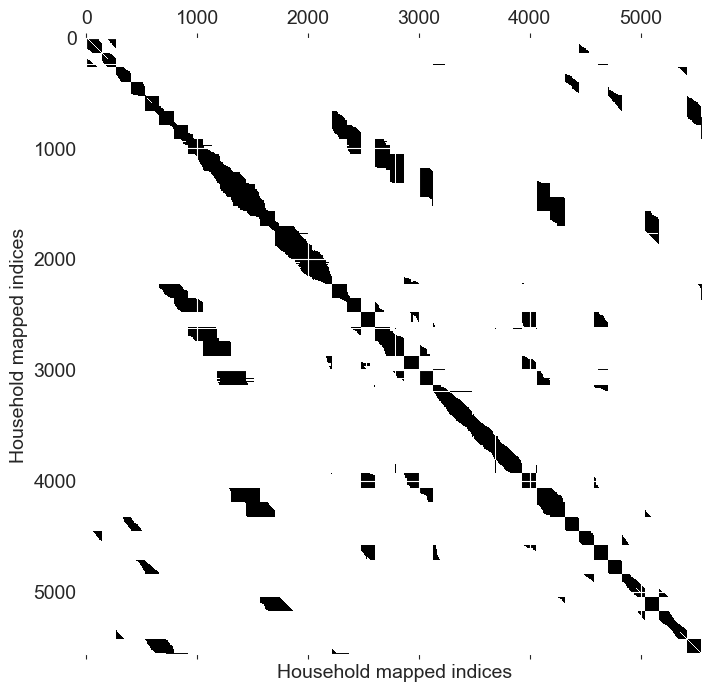

In [58]:
plt.spy(sp.sparse.bsr_matrix.toarray(adjacency_matrix))
plt.xlabel("Household mapped indices")
plt.ylabel("Household mapped indices")
plt.show()

In [59]:
df = pd.DataFrame({
    'DateTime': pd.date_range(start='2012-01-01 00:00:00', end='2013-12-31 23:00:00', freq='1h')
})
train_months=2
test_months=1
batch_size=48
overlap_months=0
# Training data
train_test_blocks=blocked_cross_validation_idx(df, train_months, test_months, overlap_months)[0]
batch_windows = get_train_batch_blocks(train_test_blocks[0],train_test_blocks[1],batch_size=batch_size)
# Validation data
validation_data=blocked_cross_validation_idx(df,train_months,test_months,overlap_months)[1]
validation_batch_windows = get_train_batch_blocks(validation_data[0],validation_data[1],batch_size=batch_size)

In [60]:
train_test_blocks, validation_data

((0, 1439, 1440, 2183), (2184, 3647, 3648, 4367))

In [68]:
val_dataset = utils.TemporalGraphDataset(adjacency_matrix, df_agg)
for b, window_idx in enumerate(validation_batch_windows):
    val_dataset.add_batch_instance(window_idx, b)

## Load G-VAR model

In [99]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Initialize the model
in_channels = 1 # 1 feature
out_channels = 1 # 1 feature
K = 2 # order of polynomial filter
P = 12 # window size

model_gvar = utils.TemporalGCN(in_channels, out_channels, K, P).to(device)
# # Load the model parameters
model_gvar.load_state_dict(torch.load('models/model_parameters_T12_K2_Epoch200.pth'))
model_gvar.eval()  # Set the model to evaluation mode if you are using it for inference

TemporalGCN(
  (gcn_layer): TemporalGCNLayer()
)

In [100]:
val_dataset.get_batch_instance(0)[2184]

Data(x=[1266, 1], edge_index=[2, 199052], edge_weight=[199052])

In [101]:
len(val_dataset.get_batch_instance(0).keys())

48

In [102]:
# def forward(self, dataset) -> Tensor:
#     # keys of the given dataset as tensor
#     indices = torch.Tensor(list(dataset.keys())).int()
#     batch_size = len(indices) # 128
#     first_idx = indices[0].item() # since it is a tensor

#     # Intialize output tensor # (428, 104)
#     out = torch.zeros(dataset[first_idx].x.shape[0], batch_size - self.P).to(device)

#     # Cache adjacency matrices and feature matrices
#     adj_matrices = []
#     x_t_matrices = []

#     for i in range(first_idx, first_idx + batch_size):
#         edge_index = dataset[i].edge_index.long().to(device)
#         edge_weight = dataset[i].edge_weight.to(device)
#         adj_sparse_tensor = SparseTensor(row = edge_index[0], col = edge_index[1], value = edge_weight)
#         adj_matrices.append(adj_sparse_tensor)
#         x_t_matrices.append(dataset[i].x.to(device))

#     # Compute the output using cached matrices
#     for i_p in range(batch_size - self.P):
#         out_kp = torch.zeros_like(x_t_matrices[0]).to(device)

#         for p in range(self.P):
#             idx = i_p + p
#             x_t_minus_p = x_t_matrices[idx]
#             adj_sparse_tensor = adj_matrices[idx]

#             for k in range(self.K + 1):
#                 h_kp = self.h[k, p]
#                 out_kp += h_kp * self.propagate(adj_sparse_tensor, x = x_t_minus_p, k = k)

#         out[:, i_p] = out_kp.view(-1)

#     return self.m(out)

# def propagate(self, adj_sparse_tensor, x = None, k = 1):
#     x_out = x
#     for _ in range(k):
#         x_out = adj_sparse_tensor.matmul(x_out)
#     return x_out

In [111]:
print(f"Length P: {len(val_dataset.get_batch_instance(0).keys())} and number nodes first batch: {val_dataset.get_batch_instance(0)[2184].x.shape[0]}")

Length P: 48 and number nodes: 1266


In [107]:
batch = validation_batch_windows[0]
# Forward pass
predict = model_gvar(val_dataset.get_batch_instance(0))

target = utils.get_target(batch, val_dataset.get_all_nodes(0), P, df_agg)
print(predict.shape, target.shape)

torch.Size([1266, 36]) torch.Size([1266, 36])


In [ ]:
batch_losses = []
for i, batch in enumerate(test_batch_windows):
    model.eval()
    optimizer.zero_grad()
    # Forward pass
    predict = model(test_dataset.get_batch_instance(i))

    target = utils.get_target(batch, test_dataset.get_all_nodes(i), P)

    loss = criterion(predict, target)
    batch_losses.append(loss.item())

# Train ARIMA models for random sample of nodes

In [6]:
# Set seed for reproducibility
seed = 1997
np.random.seed(seed)
random_households = np.random.choice(df_agg.columns, 5)
print(random_households)

[4553 2962  299  456 5354]


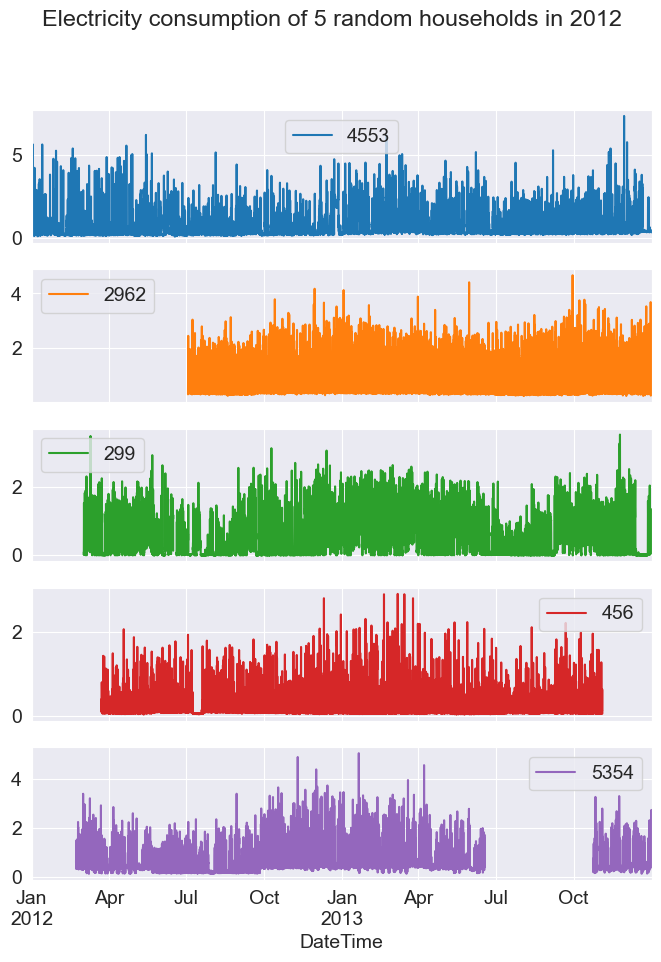

In [7]:
five_households = df_agg[random_households]
five_households.plot(subplots=True, figsize=(8, 10), title="Electricity consumption of 5 random households in 2012")
train_start = train_test_blocks[0]
train_end = train_test_blocks[1]
val_start = validation_data[0]
train_data = five_households.iloc[train_start:train_end, :].copy()


In [8]:
# Select node as
sarimax_models = []

for node in random_households:
    print(f"Building ARIMA model for node {node}")
    # Build ARIMA model for node
    sarimax_res = arima.build_arima_model_for_node(train_data, node, impute_data=True)
    sarimax_models.append(sarimax_res)


Building ARIMA model for node <class 'numpy.int64'>
Imputing missing values.
Create SARIMAX model.
Fitting SARIMAX model.


/Users/saschimi/Documents/github/ml4gd-project-group-3/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/Users/saschimi/Documents/github/ml4gd-project-group-3/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Done.
Building ARIMA model for node <class 'numpy.int64'>
Imputing missing values.
Create SARIMAX model.
Fitting SARIMAX model.


/Users/saschimi/Documents/github/ml4gd-project-group-3/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/Users/saschimi/Documents/github/ml4gd-project-group-3/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/saschimi/Documents/github/ml4gd-project-group-3/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Done.
Building ARIMA model for node <class 'numpy.int64'>
Imputing missing values.
Create SARIMAX model.
Fitting SARIMAX model.


/Users/saschimi/Documents/github/ml4gd-project-group-3/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/Users/saschimi/Documents/github/ml4gd-project-group-3/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/saschimi/Documents/github/ml4gd-project-group-3/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Done.
Building ARIMA model for node <class 'numpy.int64'>
Imputing missing values.
Create SARIMAX model.
Fitting SARIMAX model.


/Users/saschimi/Documents/github/ml4gd-project-group-3/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/Users/saschimi/Documents/github/ml4gd-project-group-3/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/saschimi/Documents/github/ml4gd-project-group-3/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Done.
Building ARIMA model for node <class 'numpy.int64'>
Imputing missing values.
Create SARIMAX model.
Fitting SARIMAX model.


/Users/saschimi/Documents/github/ml4gd-project-group-3/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


Done.


In [14]:
# Apply the first SARIMAX model to unseen data of the first household
# Select the first household
node = random_households[0]
# Select the first model
sarimax_res = sarimax_models[0]
# Select the first validation data
val_data = five_households[node].iloc[val_start:].copy()

DateTime
2012-04-01 00:00:00    0.293
2012-04-01 01:00:00    0.223
2012-04-01 02:00:00    0.297
2012-04-01 03:00:00    0.219
2012-04-01 04:00:00    0.180
                       ...  
2013-12-31 19:00:00    0.363
2013-12-31 20:00:00    0.353
2013-12-31 21:00:00    0.422
2013-12-31 22:00:00    0.324
2013-12-31 23:00:00    0.363
Name: 4553, Length: 15360, dtype: float64

In [ ]:
dataset = TemporalGraphDataset(adjacency_matrix, df_agg)
for b, window_idx in enumerate(batch_windows):
    dataset.add_batch_instance(window_idx, b)

In [13]:
sarimax_res = sarimax_res.apply(val_data)

/Users/saschimi/Documents/github/ml4gd-project-group-3/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/Users/saschimi/Documents/github/ml4gd-project-group-3/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


In [ ]:
predictions = []
# Plot seven last 7 days of fitted data and 7 days ahead (24 hours * 7 = 168)
predictions.append(sarimax_res.predict(start=train_end-168, end=val_start+168))